In [1]:
import treecorr
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# these are the GLASS imports: cosmology and everything in the glass namespace
from astropy.io import fits
import healpy as hp
# also needs camb itself to get the parameter object

import sys
sys.path.append('../src')
import glass_mock
from importlib import reload
reload(glass_mock)
import generate_mocksys
reload(generate_mocksys)
import glass.shells

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

# Define some simple selection functions

In [2]:
p1 = np.poly1d([-0.2, 1, 0.5])
p2 = np.poly1d([0.3, 0.7])
p3_tri = generate_mocksys.trig_func(0.01, 0.5, 0, 0.8)
p3_lin = np.poly1d([0.15, 0])
p3 = lambda x: p3_tri(x)+p3_lin(x)

deplfuncs = [p1, p2, p3]

# Define the configuration for GLASS

In [3]:
import camb

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05
ns = 0.96
sigma8 = 0.8
bias = 1

# basic parameters of the simulation
nside = 2048
lmax = nside * 3

# create a cosmology object
# uniform (in volume) source distribution with given angular density
# galaxy density
n_arcmin2 = 1.0

z = np.linspace(0, 2, 201)
dz = (z[-1]-z[0])/z.size
dndz = np.exp(-(z-0.3)**2/2/0.1**2)   # assume some simple n(z)
dndz /= (dndz.sum()*dz)

zb = glass.shells.redshift_grid(z[0], z[-1], dz=0.1)
# tophat window functions for shells
ws = glass.shells.tophat_windows(zb, dz=0.01)
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, WantTransfer = True, NonLinear=camb.model.NonLinear_both, halofit_version='takahashi')
#%time cls = glass.ext.camb.matter_cls(pars, lmax, ws, limber=True, limber_lmin=0)
#%time gls = glass.fields.lognormal_gls(cls, lmax=4320)  # uncomment this line if you want to calculate gls but this will take time.
# np.savetxt('../../data/mock_gls.npy', gls)

gls = np.loadtxt('../../data/mock_gls.npy')

In [4]:
reload(glass_mock)

vec_vertices = hp.ang2vec(np.array([0, 0, 100, 100]), np.array([5, -5, -5, 5]), lonlat=True)
vis = np.zeros(hp.nside2npix(nside))
vis[hp.query_polygon(nside, vec_vertices)] = 1
vis_weight = vis.copy()  # here we assume that all the pixel is fully observed, which might not be true in real case, for which one needs a "vis_weight" map to specify the coverage of each pixel on the healpix map.

glasscat = f'../../data/glass_testgalcat_depl.fits'
ra = fits.getdata(glasscat)['RA']
dec = fits.getdata(glasscat)['DEC']
keep = fits.getdata(glasscat)['keep_sys']
keep_ds = fits.getdata(glasscat)['keep_desample']


In [5]:
glasscat_unirand = f'../../data/glass_testrandcat_depl.fits'
ra_unirand = fits.getdata(glasscat_unirand)['RA']
dec_unirand = fits.getdata(glasscat_unirand)['DEC']
keep_unirand = fits.getdata(glasscat_unirand)['keep_sys']
keep_ds_unirand = fits.getdata(glasscat_unirand)['keep_desample']


In [9]:
n_arcmin2_sel = keep_ds_unirand.sum() / (vis.sum()*hp.nside2pixarea(hp.npix2nside(vis.size), degrees=True) * 3600) # this is the fraction of the area that is covered by the randoms

In [24]:
glasscat_orrand = f'../../data/glass_testgalcat_orrand_density.fits'
glasscat_true_orrand = f'../../data/glass_testgalcat_true_orrand_density.fits'
or_weight = hp.read_map('../../data/glass_OR_weights.fits', field=0)
#true_or = hp.read_map('../../data/glass_true_OR_weights.fits', field=0)

glass_mock.glass_mock_randoms(bias, n_arcmin2_sel*5, z, dndz, vis, 1024, glasscat_orrand, or_weight=or_weight)
#glass_mock.glass_mock_randoms(bias, n_arcmin2*5, z, dndz, vis, 1024, glasscat_true_orrand, or_weight=true_or)


20it [00:07,  2.82it/s]


0.5417081067589681 of galaxies are kept!
12628672 galaxies are generated!


# Calculate $w(\theta)$ with `treecorr`

## Use the reconstructed OR as random sample with depleted galaxy sample:

In [25]:
import treecorr
from treecorr_utils import *

catd_depleted = treecorr.Catalog(ra = ra[keep.astype(bool)], dec=dec[keep.astype(bool)], ra_units='deg', dec_units='deg', npatch=30)
catr_som_or = treecorr.Catalog(glasscat_orrand, ra_col="RA", dec_col="Dec", ra_units='deg', dec_units='deg', patch_centers=catd_depleted.patch_centers)
theta_som_hp_or , w_som_hp_or, cov_som_hp_or = treecorr_NNcor(catd_depleted, catr_som_or, nbins=20, max_sep=250, min_sep = 2.5, var_method='bootstrap')

## Use a uniform random sample with depleted galaxy sample:

In [15]:
catr_true_or = treecorr.Catalog(ra = ra_unirand[keep_unirand.astype(bool)], dec=dec_unirand[keep_unirand.astype(bool)], ra_units='deg', dec_units='deg', patch_centers=catd_depleted.patch_centers)
catr_ur = treecorr.Catalog(ra=ra_unirand[keep_ds_unirand.astype(bool)], dec=dec_unirand[keep_ds_unirand.astype(bool)], ra_col="RA", dec_col="Dec", ra_units='deg', dec_units='deg', patch_centers=catd_depleted.patch_centers)
theta_ur , w_ur, cov_ur = treecorr_NNcor(catd_depleted, catr_ur, nbins=20, max_sep=250, min_sep = 2.5, var_method='bootstrap')

## Use a depleted random sample (by the true OR) with depleted galaxy sample:

In [16]:
theta_true_or , w_true_or, cov_true_or = treecorr_NNcor(catd_depleted, catr_true_or, nbins=20, max_sep=250, min_sep = 2.5, var_method='bootstrap')

## Use a uniform random sample with uniformly depleted galaxy sample

In [17]:
catd_unbiased = treecorr.Catalog(ra=ra[keep_ds.astype(bool)], dec=dec[keep_ds.astype(bool)], ra_units='deg', dec_units='deg', patch_centers=catd_depleted.patch_centers)
theta_unbiased, w_unbiased, cov_unbiased = treecorr_NNcor(catd_unbiased, catr_ur, nbins=20, max_sep=250, min_sep = 2.5, var_method='bootstrap')

# Calculate theoretical $w(\theta)$

In [18]:
import pyccl

cosmo_pyccl = pyccl.Cosmology(Omega_c=Oc, Omega_b=Ob, h=h, n_s=0.96, A_s = pars.InitPower.As)
gtracer = pyccl.NumberCountsTracer(cosmo_pyccl, has_rsd=False, dndz=(z, dndz), bias=(z, np.ones_like(z)))

ell = np.linspace(0, 5000, 5000)
cell = pyccl.angular_cl(cosmo_pyccl, gtracer, gtracer, ell)
w_theory = pyccl.correlation(cosmo_pyccl, ell, cell, theta_ur/60)

# Plot them!

Text(0, 0.5, '$\\theta w(\\theta)$')

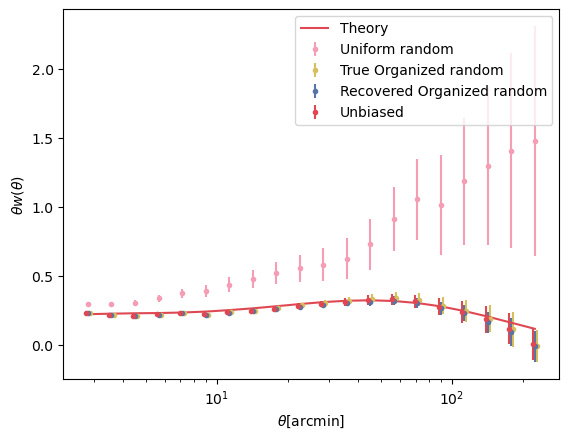

In [26]:
colors_btr = {'ur': '#f49db5',
              'true_or': '#d7bf5e',
              'som_or':'#5675a5',
              'unbiased':'#df4853',
              'black':'k'}

w_theory = pyccl.correlation(cosmo_pyccl, ell, cell, theta_ur/60)
plt.errorbar(theta_ur, theta_ur*w_ur, label='Uniform random', yerr=theta_ur * np.diag(cov_ur) ** 0.5, fmt='.', color=colors_btr['ur'])
plt.errorbar(theta_true_or*1.02, theta_true_or*w_true_or, label='True Organized random', yerr=theta_true_or * np.diag(cov_true_or) ** 0.5, fmt='.', color=colors_btr['true_or'])
plt.errorbar(theta_som_hp_or, theta_som_hp_or*w_som_hp_or, label='Recovered Organized random', yerr=theta_som_hp_or * np.diag(cov_som_hp_or) ** 0.5, fmt='.', color=colors_btr['som_or'])
plt.errorbar(theta_unbiased/1.02, theta_unbiased*w_unbiased, label='Unbiased', yerr=theta_unbiased * np.diag(cov_unbiased) ** 0.5, fmt='.', color=colors_btr['unbiased'])
plt.xscale('log')
plt.semilogx(theta_ur, theta_ur*w_theory, label='Theory', color=colors_btr['unbiased'])
plt.legend()
plt.xlabel(r'$\theta$[arcmin]')
plt.ylabel(r'$\theta w(\theta)$')

#plt.axvline(pixscale*2**0.5, 0, 1, color='k')
#plt.ylim(0.01, 30)

(0.0, 2.0)

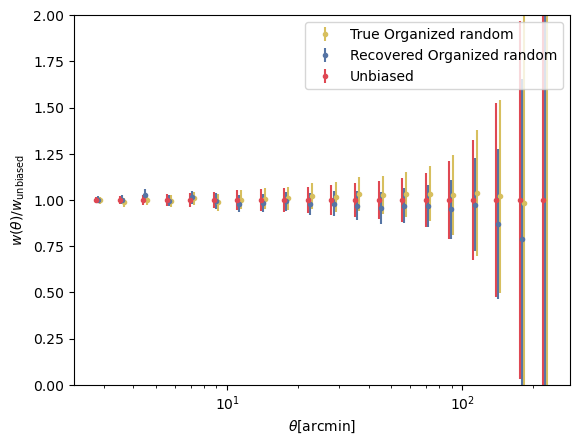

In [27]:
w_theory = pyccl.correlation(cosmo_pyccl, ell, cell, theta_ur/60)
plt.errorbar(theta_true_or*1.02, w_true_or/w_unbiased, label='True Organized random', yerr=np.diag(cov_true_or) ** 0.5/w_unbiased, fmt='.', color=colors_btr['true_or'])
plt.errorbar(theta_som_hp_or, w_som_hp_or/w_unbiased, label='Recovered Organized random', yerr=np.diag(cov_som_hp_or) ** 0.5/w_unbiased, fmt='.', color=colors_btr['som_or'])
plt.errorbar(theta_unbiased/1.02, w_unbiased/w_unbiased, label='Unbiased', yerr=np.diag(cov_unbiased) ** 0.5/w_unbiased, fmt='.', color=colors_btr['unbiased'])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\theta$[arcmin]')
plt.ylabel(r'$w(\theta)/w_{\mathrm{unbiased}}$')
plt.ylim(0, 2)

(-1.0, 1.0)

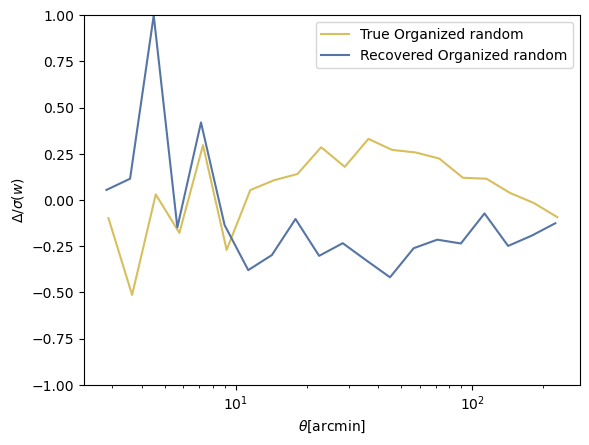

In [33]:
w_theory = pyccl.correlation(cosmo_pyccl, ell, cell, theta_ur/60)
plt.plot(theta_true_or*1.02, (w_true_or-w_unbiased)/np.diag(cov_true_or) ** 0.5, label='True Organized random',color=colors_btr['true_or'])
plt.plot(theta_som_hp_or, (w_som_hp_or-w_unbiased)/np.diag(cov_true_or) ** 0.5, label='Recovered Organized random', color=colors_btr['som_or'])

plt.xscale('log')
plt.legend()
plt.xlabel(r'$\theta$[arcmin]')
plt.ylabel(r'$\Delta/\sigma (w)$')
plt.ylim(-1, 1)

## also plot the standard deviations

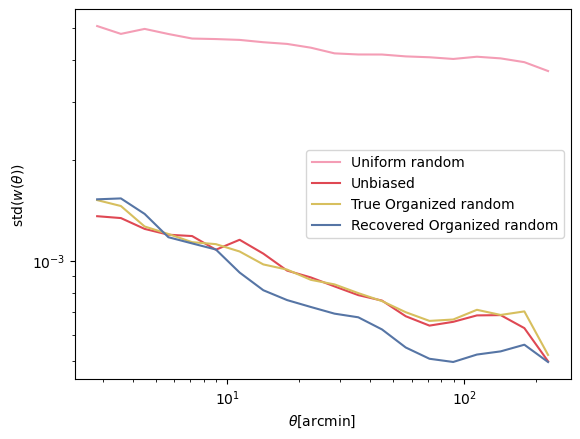

In [28]:

w_theory = pyccl.correlation(cosmo_pyccl, ell, cell, theta_ur/60)
plt.plot(theta_ur, np.diag(cov_ur) ** 0.5, label='Uniform random', color=colors_btr['ur'])
plt.plot(theta_unbiased, np.diag(cov_unbiased) ** 0.5, label='Unbiased', color=colors_btr['unbiased'])
plt.plot(theta_true_or, np.diag(cov_true_or) ** 0.5, label='True Organized random', color=colors_btr['true_or'])
plt.plot(theta_som_hp_or, np.diag(cov_som_hp_or) ** 0.5, label='Recovered Organized random', color=colors_btr['som_or'])
plt.legend()
plt.xlabel(r'$\theta$[arcmin]')
plt.ylabel(r'std$(w(\theta))$')
plt.yscale('log')
plt.xscale('log')